## Model interpretability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '..')
from readability_experiments.data_loader import DataLoaderBase

loader = DataLoaderBase("../data/wikireadability/")
loader.load_data()

/Users/trokhymovych/Library/Caches/pypoetry/virtualenvs/readability-experiments-9T8f72h3-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 17/17 [00:09<00:00,  1.75it/s]

Length of data:  112342
Train size: 89873. Test size: 22469


In [3]:
import textstat
from tqdm import tqdm

# Calculation of FK score: 
def predict(testset):
    for file in tqdm(testset.files):
        for pair in testset.data[file]:
            for sample in pair:
                sample.score = textstat.flesch_kincaid_grade(" ".join(sample.sentences))
    return testset

predicted_dataset = predict(loader.testsets)

100%|██████████| 17/17 [00:38<00:00,  2.28s/it]


In [4]:
import os
directory = "../data/metrics/"
filename_scores = None
for filename in os.listdir(directory):
    if ("all_scores__Transformer_based_ranker" in filename) and ("sentence" not in filename):
        filename_scores = filename
        break
print("Loading scores from file:", filename_scores)

dataset = pd.read_csv(directory + filename_scores)
scores_dataset = dataset[dataset['file'] == 'simplewiki-en_sentences.bz2']

fk_dict = {}
for pair in predicted_dataset.data["simplewiki-en_sentences.bz2"]:
    for sample in pair:
        fk_dict[(sample.title, sample.difficulty)] = sample.score
fk_scores = []
for index, row in scores_dataset.iterrows():
    fk_scores.append(fk_dict[(row['title'], row['difficulty'])])
scores_dataset['fk_score'] = fk_scores


Loading scores from file: all_scores__Transformer_based_ranker_11476.449100494385.csv


/var/folders/hy/3zvjkf9d35q17_14pc7rwjxh0000gn/T/ipykernel_69087/927607854.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_dataset['fk_score'] = fk_scores


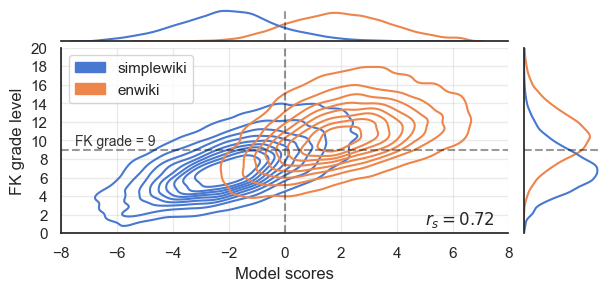

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set(style="white", palette="muted", color_codes=True)
g = sns.jointplot(
    x='score', 
    y='fk_score', 
    hue="difficulty",
    data=scores_dataset, 
    kind="kde", 
    color="b", 
    height=4,
    legend=False
)

g.fig.set_figwidth(7)
g.fig.set_figheight(2.85)

g.fig.subplots_adjust(top=0.95)
g.ax_joint.grid(True)
g.ax_joint.set_xlim(right=8, left=-8)
g.ax_joint.set_ylim(top=20, bottom=0)

rs = scores_dataset['score'].corr(scores_dataset['fk_score'], method="spearman")
g.ax_joint.text(5, 1, f"$r_s = {round(rs, 2)}$", fontsize=12)

difficulties = ["simplewiki", "enwiki"]
colors = sns.color_palette("muted", len(difficulties))
patches = [mpatches.Patch(color=c, label=d) for c, d in zip(colors, difficulties)]
g.ax_joint.legend(handles=patches, loc='upper left')
g.set_axis_labels("Model scores", "FK grade level")
g.ax_joint.grid(alpha=0.4)
g.ax_joint.axvline(x=0, color='black', linestyle='--', alpha=0.4)
g.ax_marg_x.axvline(x=0, color='black', linestyle='--', alpha=0.4)
g.ax_joint.axhline(y=9, color='black', linestyle='--', alpha=0.4)
g.ax_joint.text(-7.5, 9.5, "FK grade = 9", fontsize=10, color='black', alpha=0.8)
g.ax_marg_y.axhline(y=9, color='black', linestyle='--', alpha=0.4)
g.ax_joint.set_xticks(np.arange(-8, 9, 2))
g.ax_joint.set_yticks(np.arange(0, 21, 2))
g.fig.savefig('fk_scores_model_plot.png', dpi=300)
plt.show()

# Scores distribution:

In [54]:
scores = pd.read_csv("../data/wikireadability_sample/results_text_ranker.csv")
scores['file'] = scores['file'].apply(lambda x: x.split("_")[1])
scores.head()

file                                              title     score
0  itwiki      Supercoppa Italiana 2016 (pallamano maschile)  1.297786
1  itwiki                      True (singolo Spandau Ballet)  2.294625
2  itwiki                  Premio Nigeria per la letteratura  2.332937
3  itwiki  Orange Prokom Open 2004 - Qualificazioni singo...  2.202860
4  itwiki                                              Beige  2.889751

/var/folders/hy/3zvjkf9d35q17_14pc7rwjxh0000gn/T/ipykernel_69087/2557805914.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


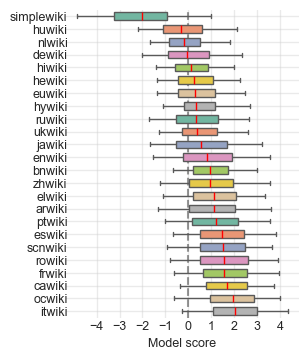

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 4))
sns.set_style("whitegrid")

fontsize=9

plt.axvline(x=0, color='black', linestyle='--', alpha=0.4, linewidth=1.5)
sns.boxplot(
    y="file", x="score", data=scores, 
    palette="Set2", showfliers=False, whis=[5, 95], 
    order=scores.groupby("file")["score"].median().sort_values().index,
    medianprops={"color":"red"},
    width=0.6
)


plt.ylabel("")
plt.xticks([-4,-3, -2,-1, 0, 1, 2, 3, 4])
plt.xlabel("Model score", fontsize=fontsize)
plt.xticks(ha="center", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(alpha=0.4)
plt.gca().tick_params(axis='y', pad=-7)
plt.gca().tick_params(axis='x', pad=-4)
plt.box(on=None)


plt.savefig("fk_scores_boxplot_vertical.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
scores.groupby("file")["score"].median().sort_values()

file
simplewiki   -2.036688
huwiki       -0.317479
nlwiki       -0.199661
dewiki       -0.059510
hiwiki        0.129039
hewiki        0.254885
euwiki        0.301839
hywiki        0.323224
ruwiki        0.344140
ukwiki        0.366789
jawiki        0.546576
enwiki        0.799472
bnwiki        0.927998
zhwiki        0.940228
elwiki        1.105434
arwiki        1.119659
ptwiki        1.185189
eswiki        1.460383
scnwiki       1.502118
rowiki        1.535415
frwiki        1.566884
cawiki        1.662561
ocwiki        1.940838
itwiki        2.021544
Name: score, dtype: float64

# Calculating correlations for testing set:

In [48]:
from readability_experiments.data_loader import DataLoaderBase
from readability_experiments.models import models

model = models[1]
print(model.name)

loader = DataLoaderBase("../data/wikireadability/")
loader.load_data(split_strategy="no_split")

English flesch_reading_ease baseline


100%|██████████| 17/17 [00:11<00:00,  1.43it/s]


In [49]:
import time
start_time = time.time()
processed_dataset = model.predict(loader.trainsets)
time_elapsed = time.time() - start_time

100%|██████████| 17/17 [01:18<00:00,  4.64s/it]


In [50]:
files = []
titles = []
scores = []
difficulty = []
for file in processed_dataset.files:
    for page in processed_dataset.data[file]:
        files.append(file)
        titles.append(page[0].title)
        scores.append(1 / page[0].score - 0.1)  # Reverse function as it is processed in the module. 
        difficulty.append(str(page[0].difficulty.value))
        files.append(file)
        titles.append(page[1].title)
        scores.append(1 / page[1].score - 0.1)
        difficulty.append(str(page[1].difficulty.value))

df_readability_scores = pd.DataFrame({"file": files, "title": titles, "difficulty": difficulty, "fre_score": scores})
df_readability_scores.head()

file            title difficulty  fre_score
0  vikidia-oc_sentences.bz2          Francés       easy      70.50
1  vikidia-oc_sentences.bz2          Francés       hard      61.26
2  vikidia-oc_sentences.bz2  The_Cranberries       easy      62.04
3  vikidia-oc_sentences.bz2  The_Cranberries       hard      68.40
4  vikidia-oc_sentences.bz2      Simone_Veil       easy      77.03

In [51]:
# Loading model precalculated scores and joining with readability scores:
df_scores = pd.read_csv(directory + filename_scores)
scores_dataset = df_scores.merge(df_readability_scores, on=['file', 'title', 'difficulty'], how='left')
scores_dataset['model_score'] = scores_dataset['score'].values


In [52]:
tmp = scores_dataset.groupby("file")[['fre_score', 'model_score']].corr("spearman").sort_values(by='fre_score', ascending=False)
tmp = tmp[tmp['fre_score'] < 1]
tmp.columns = ['correlation', 'model_score']
tmp["correlation"]

file                                    
vikidia-hy_sentences.bz2     model_score   -0.267741
vikidia-scn_sentences.bz2    model_score   -0.345243
vikidia-ru_sentences.bz2     model_score   -0.427047
vikidia-eu_sentences.bz2     model_score   -0.490327
txikipedia-eu_sentences.bz2  model_score   -0.493230
vikidia-el_sentences.bz2     model_score   -0.557519
vikidia-oc_sentences.bz2     model_score   -0.564348
wikikids-nl_sentences.bz2    model_score   -0.618043
simplewiki-en_sentences.bz2  model_score   -0.626536
vikidia-pt_sentences.bz2     model_score   -0.636989
vikidia-fr_sentences.bz2     model_score   -0.647101
vikidia-es_sentences.bz2     model_score   -0.666415
vikidia-de_sentences.bz2     model_score   -0.670547
vikidia-ca_sentences.bz2     model_score   -0.715038
vikidia-en_sentences.bz2     model_score   -0.716007
vikidia-it_sentences.bz2     model_score   -0.761011
klexikon-de_sentences.bz2    model_score   -0.808122
Name: correlation, dtype: float64